<a target="_blank" href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/1-Introduction/Stock_NeurIPS2018_SB3.py">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



# Content

* [1. Task Description](#0)
* [2. Install Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. A List of Python Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download and Preprocess Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5. Build Market Environment in OpenAI Gym-style](#4)  
    * [5.1. Data Split](#4.1)  
    * [5.3. Environment for Training](#4.2)    
* [6. Train DRL Agents](#5)
* [7. Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
  

<a id='0'></a>
# Part 1. Task Discription

We train a DRL agent for stock trading. This task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes many features and learns by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 consituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.


The data for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Install Python Packages

<a id='1.1'></a>
## 2.1. Install packages


In [ ]:
# ## install required packages
# !pip install swig
# !pip install wrds
# !pip install pyportfolioopt
# ## install finrl library
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/skazgor/FinRL.git


<a id='1.2'></a>
## 2.2. A list of Python packages 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

/home/ruhul/RL/Stock-Trader/.conda/lib/python3.10/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


<a id='1.4'></a>
## 2.4. Create Folders

In [2]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



<a id='2'></a>
# Part 3. Download Data
Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).



-----
class YahooDownloader:
    Retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()


In [3]:
# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE
# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

'2020-07-31'

In [4]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-10-01'
TRADE_START_DATE = '2021-10-01'
TRADE_END_DATE = '2023-03-01'

In [5]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = config_tickers.DOW_30_TICKER).fetch_data()
df.shape

/home/ruhul/RL/Stock-Trader/.conda/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
/home/ruhul/RL/Stock-Trader/.conda/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
/home/ruhul/RL/Stock-Trader/.conda/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_h

Shape of DataFrame:  (97013, 8)


(97013, 8)

In [6]:
import seaborn as sns
# Assuming 'df' is your DataFrame and 'close' is the column with closing prices
std_dev = df.groupby('tic')['close'].std()

plt.figure(figsize=(10,6))
sns.histplot(std_dev, bins=50, kde=True)
plt.title('Distribution of std of the stocks')
plt.xlabel('Standard Deviation')
plt.ylabel('Frequency')
plt.savefig('output.png')
plt.show()

/home/ruhul/RL/Stock-Trader/.conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_52532/3820035714.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [7]:
print(config_tickers.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [8]:
new_df = df[['tic','close']]
new_df.groupby('tic').describe()

close                                                             \
       count        mean         std        min         25%         50%   
tic                                                                       
AAPL  3311.0   50.229139   48.284805   5.806767   16.582760   27.677065   
AMGN  3311.0  130.464192   64.251647  34.700050   73.508244  127.507729   
AXP   3311.0   83.610968   39.171012  29.972874   53.005100   75.136871   
BA    3311.0  161.945656   98.371482  43.777550   74.275791  129.789993   
CAT   3311.0  103.414874   51.834250  35.222431   64.346508   79.558960   
CRM   3311.0  104.064591   71.048752  15.520000   42.502501   77.250000   
CSCO  3311.0   28.008917   13.273221   9.455711   16.296296   23.904316   
CVX   3311.0   82.390485   26.356999  39.029667   65.741718   77.779053   
DIS   3311.0   91.222944   41.751042  25.453197   55.020798   96.411118   
DOW    994.0   46.189472    9.087612  18.160522   39.498597   46.957884   
GS    3311.0  182.074709   77.039890  70.533394  130.104279  161.847672   
HD    3311.0  135.817635   96.463143  19.597719   57.126659  110.604080   
HON   3311.0  106.100516   56.453956  25.879967   57.030476   93.798798   
IBM   3311.0  107.109045   13.709417  70.936684  100.071159  107.594536   
INTC  3311.0   30.473422   13.316399  11.824527   18.106851   27.797804   
JNJ   3311.0   95.808664   39.716412  38.233303   61.851740   93.949104   
JPM   3311.0   70.121373   38.334445  20.152529   36.321646   53.727272   
KO    3311.0   35.900404   11.392327  16.373814   27.647457   33.742882   
MCD   3311.0  125.521427   65.298336  41.608913   72.226696  101.032387   
MMM   3311.0  115.117954   40.280481  47.578579   74.065605  119.695480   
MRK   3311.0   48.513098   20.834287  18.882837   31.406274   43.827957   
MSFT  3311.0   96.100621   89.324458  17.580816   26.005700   50.929375   
NKE   3311.0   61.634624   40.252917  12.955005   26.913588   51.436115   
PG    3311.0   78.855107   32.795755  39.555553   56.155523   67.354462   
TRV   3311.0   94.750254   39.558057  34.164383   63.744583   94.999428   
UNH   3311.0  178.175931  145.630995  22.725935   51.179737  124.005272   
V     3311.0  100.933874   71.043327  14.852296   38.705822   75.339859   
VZ    3311.0   33.850449   10.068162  12.851609   28.285357   33.781002   
WBA   3311.0   42.614277   14.191084  17.299438   30.027789   42.390965   
WMT   3311.0   21.239335   12.592517   6.372952   11.895372   15.449376   

                              
             75%         max  
tic                           
AAPL   60.262320  179.724548  
AMGN  180.210426  278.485199  
AXP   102.729324  192.847031  
BA    218.764999  430.299988  
CAT   127.473980  259.268188  
CRM   155.869995  309.959991  
CSCO   40.502588   59.704552  
CVX    92.509575  178.740112  
DIS   111.131615  201.254089  
DOW    53.880619   64.523323  
GS    207.938492  398.167786  
HD    198.903496  394.975555  
HON   150.058693  223.091614  
IBM   117.650303  142.149796  
INTC   42.515261   62.730942  
JNJ   123.963936  175.705063  
JPM    96.413879  160.712860  
KO     43.541197   62.817848  
MCD   178.470558  270.712006  
MMM   147.402390  202.668732  
MRK    67.205650  111.714149  
MSFT  138.383110  336.315338  
NKE    84.868534  173.070923  
PG    106.852840  156.233932  
TRV   120.905354  189.572952  
UNH   249.690804  545.235291  
V     173.212929  245.855545  
VZ     43.890781   51.301071  
WBA    55.191664   71.065689  
WMT    31.952303   49.146824

In [9]:
df.shape

(97013, 8)

In [10]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,7.622500,7.660714,7.585000,6.470742,493729600,AAPL,0
1,2010-01-04,56.630001,57.869999,56.560001,41.493416,5277400,AMGN,0
2,2010-01-04,40.810001,41.099998,40.389999,33.192947,6894300,AXP,0
3,2010-01-04,55.720001,56.389999,54.799999,43.777550,6186700,BA,0
4,2010-01-04,57.650002,59.189999,57.509998,40.336727,7325600,CAT,0


# Part 4: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

In [11]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators


/home/ruhul/RL/Stock-Trader/.conda/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (3310, 8)
Successfully added vix
Successfully added turbulence index


In [12]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [13]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-01-04,AAPL,7.622500,7.660714,7.585000,6.470742,493729600.0,0.0,0.0,6.492156,6.460514,100.0,66.666667,100.0,6.470742,6.470742,20.040001,0.0
1,2010-01-04,AMGN,56.630001,57.869999,56.560001,41.493416,5277400.0,0.0,0.0,6.492156,6.460514,100.0,66.666667,100.0,41.493416,41.493416,20.040001,0.0
2,2010-01-04,AXP,40.810001,41.099998,40.389999,33.192947,6894300.0,0.0,0.0,6.492156,6.460514,100.0,66.666667,100.0,33.192947,33.192947,20.040001,0.0
3,2010-01-04,BA,55.720001,56.389999,54.799999,43.777550,6186700.0,0.0,0.0,6.492156,6.460514,100.0,66.666667,100.0,43.777550,43.777550,20.040001,0.0
4,2010-01-04,CAT,57.650002,59.189999,57.509998,40.336727,7325600.0,0.0,0.0,6.492156,6.460514,100.0,66.666667,100.0,40.336727,40.336727,20.040001,0.0
5,2010-01-04,CRM,18.652500,18.882500,18.547501,18.705000,7906000.0,0.0,0.0,6.492156,6.460514,100.0,66.666667,100.0,18.705000,18.705000,20.040001,0.0
6,2010-01-04,CSCO,24.110001,24.840000,24.010000,16.880301,59853700.0,0.0,0.0,6.492156,6.460514,100.0,66.666667,100.0,16.880301,16.880301,20.040001,0.0
7,2010-01-04,CVX,78.199997,79.199997,78.160004,44.988220,10173800.0,0.0,0.0,6.492156,6.460514,100.0,66.666667,100.0,44.988220,44.988220,20.040001,0.0
8,2010-01-04,DIS,32.500000,32.750000,31.870001,27.843180,13700400.0,0.0,0.0,6.492156,6.460514,100.0,66.666667,100.0,27.843180,27.843180,20.040001,0.0
9,2010-01-04,GS,170.050003,174.250000,169.509995,136.536926,9135000.0,0.0,0.0,6.492156,6.460514,100.0,66.666667,100.0,136.536926,136.536926,20.040001,0.0


In [14]:
mvo_df = processed_full.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]

In [15]:
processed_full['turbulence'].max()

655.3648428317534

<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2009-01-01 to 2020-07-01

Trading data period: 2020-07-01 to 2021-10-31


In [16]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

85753
10237


In [17]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
2956,2021-09-30,UNH,401.489990,403.489990,390.459991,378.841400,3779900.0,3.0,-4.300013,414.465513,382.483309,40.895372,-222.830965,41.980385,401.350917,400.847636,23.139999,24.762
2956,2021-09-30,V,227.580002,228.789993,222.630005,218.542938,7128500.0,3.0,-1.526748,226.859204,214.843797,44.078999,-54.529609,19.569853,223.027286,229.677242,23.139999,24.762
2956,2021-09-30,VZ,54.500000,54.509998,54.000000,46.361515,18736600.0,3.0,-0.221033,47.420594,46.108471,41.824835,-102.463426,21.682953,46.922905,47.420055,23.139999,24.762
2956,2021-09-30,WBA,48.790001,48.930000,46.919998,41.084076,6449400.0,3.0,-0.236967,45.359591,40.747571,44.613720,-106.767299,0.941150,42.887237,41.925717,23.139999,24.762
2956,2021-09-30,WMT,46.880001,47.243332,46.416664,41.843067,22470705.0,3.0,-0.457438,44.929571,41.695002,40.957253,-151.323430,45.501862,43.758397,43.289727,23.139999,24.762


In [18]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2021-10-01,AAPL,141.899994,142.919998,139.110001,140.653519,94639600.0,4.0,-1.694441,154.557875,136.404111,46.927743,-142.221458,41.749873,146.390415,145.492823,21.1,120.08778
0,2021-10-01,AMGN,213.589996,214.610001,210.800003,197.213058,2629400.0,4.0,-2.996550,205.844857,192.892086,40.408549,-96.968279,36.189244,201.697196,210.039143,21.1,120.08778
0,2021-10-01,AXP,168.500000,175.119995,168.479996,168.247116,3956000.0,4.0,2.249023,172.356192,147.637361,56.265103,117.459906,15.667511,159.492023,161.711266,21.1,120.08778
0,2021-10-01,BA,222.850006,226.720001,220.600006,226.000000,9113600.0,4.0,0.730320,226.909442,205.727561,51.614047,116.649440,2.027170,217.175334,221.968500,21.1,120.08778
0,2021-10-01,CAT,192.899994,195.869995,191.240005,184.182953,3695500.0,4.0,-3.567777,201.635942,177.817140,41.999434,-112.157313,36.203176,193.068116,196.526045,21.1,120.08778


In [19]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [20]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [21]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "cash_penalty_percentage": 0.001,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

StockTradingEnv - Init


## Environment for Training



In [22]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL includes fine-tuned standard DRL algorithms, such as DQN, DDPG, Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [23]:
agent = DRLAgent(env = env_train)

if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True


### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)


### Agent 1: A2C


In [24]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)


{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c


In [25]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000) if if_using_a2c else None

---------------------------------------
| time/                 |             |
|    fps                | 119         |
|    iterations         | 100         |
|    time_elapsed       | 4           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -41.4       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | -79.8       |
|    reward             | -0.78353304 |
|    std                | 1.01        |
|    value_loss         | 3.59        |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 133        |
|    iterations         | 200        |
|    time_elapsed       | 7          |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -41.4      |
|    explained_variance | -0.207     |
|    lear

### Agent 2: DDPG

In [26]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
Logging to results/ddpg


In [27]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

day: 2956, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 4307190.94
total_reward: 3307190.94
total_cost: 1099.93
total_trades: 35495
Sharpe: 0.762
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 53       |
|    time_elapsed    | 220      |
|    total_timesteps | 11828    |
| train/             |          |
|    actor_loss      | -35.5    |
|    critic_loss     | 130      |
|    learning_rate   | 0.001    |
|    n_updates       | 11727    |
|    reward          | -8.73321 |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 52       |
|    time_elapsed    | 446      |
|    total_timesteps | 23656    |
| train/             |          |
|    actor_loss      | -29.4    |
|    critic_loss     | 3.84     |
|    learning_rate   | 0.001    |
|    n_updates       | 23555    |
|    reward          | -

### Agent 3: PPO

In [28]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to results/ppo


In [29]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000) if if_using_ppo else None

-----------------------------------
| time/              |            |
|    fps             | 191        |
|    iterations      | 1          |
|    time_elapsed    | 10         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.73730356 |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 188         |
|    iterations           | 2           |
|    time_elapsed         | 21          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.013869501 |
|    clip_fraction        | 0.204       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | -0.00618    |
|    learning_rate        | 0.00025     |
|    loss                 | 4.9         |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0243     |
|   

### Agent 4: TD3

In [30]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to results/td3


In [31]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=50000) if if_using_td3 else None

----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 70        |
|    time_elapsed    | 168       |
|    total_timesteps | 11828     |
| train/             |           |
|    actor_loss      | 170       |
|    critic_loss     | 30.4      |
|    learning_rate   | 0.001     |
|    n_updates       | 11727     |
|    reward          | -7.864337 |
----------------------------------
day: 2956, episode: 60
begin_total_asset: 1000000.00
end_total_asset: 5683304.56
total_reward: 4683304.56
total_cost: 1093.79
total_trades: 41408
Sharpe: 0.927
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 69        |
|    time_elapsed    | 338       |
|    total_timesteps | 23656     |
| train/             |           |
|    actor_loss      | 143       |
|    critic_loss     | 300       |
|    learning_rate   | 0.001     |
|    n_updates       | 23555     |


### Agent 5: SAC

In [32]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to results/sac


In [33]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=50000) if if_using_sac else None

-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 60         |
|    time_elapsed    | 195        |
|    total_timesteps | 11828      |
| train/             |            |
|    actor_loss      | 824        |
|    critic_loss     | 73.8       |
|    ent_coef        | 0.171      |
|    ent_coef_loss   | -79.7      |
|    learning_rate   | 0.0001     |
|    n_updates       | 11727      |
|    reward          | -4.5778775 |
-----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 59        |
|    time_elapsed    | 396       |
|    total_timesteps | 23656     |
| train/             |           |
|    actor_loss      | 344       |
|    critic_loss     | 17.8      |
|    ent_coef        | 0.0526    |
|    ent_coef_loss   | -126      |
|    learning_rate   | 0.0001    |
|    n_updates       | 23555     |
|    

## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [34]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [35]:
insample_risk_indicator.vix.describe()

count    2957.000000
mean       18.105293
std         7.272476
min         9.140000
25%        13.370000
50%        16.209999
75%        20.629999
max        82.690002
Name: vix, dtype: float64

In [36]:
insample_risk_indicator.vix.quantile(0.996)

57.212001831054636

In [37]:
insample_risk_indicator.turbulence.describe()

count    2957.000000
mean       34.138934
std        43.919434
min         0.000000
25%        14.623685
50%        23.621277
75%        38.338429
max       655.364843
Name: turbulence, dtype: float64

In [38]:
# plot the distribution of the turbulence
plt.figure(figsize=(10,6))
sns.histplot(insample_risk_indicator.turbulence, bins=50, kde=True)
plt.title('Distribution of turbulence of DJI top 30 stocks')
plt.xlabel('Turbulence')
plt.ylabel('Frequency')
plt.savefig('turbulenceOFdji.png')
plt.show()

/home/ruhul/RL/Stock-Trader/.conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_52532/3617080224.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [39]:
insample_risk_indicator.turbulence.quantile(0.996)

291.6181954996124

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [40]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

StockTradingEnv - Init


In [41]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2021-10-01,AAPL,141.899994,142.919998,139.110001,140.653519,94639600.0,4.0,-1.694441,154.557875,136.404111,46.927743,-142.221458,41.749873,146.390415,145.492823,21.1,120.08778
0,2021-10-01,AMGN,213.589996,214.610001,210.800003,197.213058,2629400.0,4.0,-2.996550,205.844857,192.892086,40.408549,-96.968279,36.189244,201.697196,210.039143,21.1,120.08778
0,2021-10-01,AXP,168.500000,175.119995,168.479996,168.247116,3956000.0,4.0,2.249023,172.356192,147.637361,56.265103,117.459906,15.667511,159.492023,161.711266,21.1,120.08778
0,2021-10-01,BA,222.850006,226.720001,220.600006,226.000000,9113600.0,4.0,0.730320,226.909442,205.727561,51.614047,116.649440,2.027170,217.175334,221.968500,21.1,120.08778
0,2021-10-01,CAT,192.899994,195.869995,191.240005,184.182953,3695500.0,4.0,-3.567777,201.635942,177.817140,41.999434,-112.157313,36.203176,193.068116,196.526045,21.1,120.08778


In [42]:
trained_moedl = trained_a2c
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [43]:
df_account_value_a2c.max()

date                 2023-02-27
account_value    1124202.459354
dtype: object

In [44]:
trained_moedl = trained_ddpg
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [45]:
trained_moedl = trained_ppo
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [46]:
trained_moedl = trained_td3
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [47]:
trained_moedl = trained_sac
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [48]:
df_account_value_a2c.shape

(353, 2)

<a id='7'></a>
# Part 6.5: Mean Variance Optimization

In [49]:
mvo_df.head()

,date,tic,close
0,2010-01-04,AAPL,6.470742
1,2010-01-04,AMGN,41.493416
2,2010-01-04,AXP,33.192947
3,2010-01-04,BA,43.777550
4,2010-01-04,CAT,40.336727


In [50]:
fst = mvo_df
fst = fst.iloc[0*29:0*29+29, :]
tic = fst['tic'].tolist()

mvo = pd.DataFrame()

for k in range(len(tic)):
  mvo[tic[k]] = 0

for i in range(mvo_df.shape[0]//29):
  n = mvo_df
  n = n.iloc[i*29:i*29+29, :]
  date = n['date'][i*29]
  mvo.loc[date] = n['close'].tolist()

In [51]:
mvo.shape[0]

3310

### Helper functions

In [52]:
from scipy import optimize 
from scipy.optimize import linprog

#function obtains maximal return portfolio using linear programming

def MaximizeReturns(MeanReturns, PortfolioSize):
    
  #dependencies
  
    
  c = (np.multiply(-1, MeanReturns))
  A = np.ones([PortfolioSize,1]).T
  b=[1]
  res = linprog(c, A_ub = A, b_ub = b, bounds = (0,1), method = 'simplex') 
    
  return res

def MinimizeRisk(CovarReturns, PortfolioSize):
    
  def f(x, CovarReturns):
    func = np.matmul(np.matmul(x, CovarReturns), x.T) 
    return func

  def constraintEq(x):
    A=np.ones(x.shape)
    b=1
    constraintVal = np.matmul(A,x.T)-b 
    return constraintVal
    
  xinit=np.repeat(0.1, PortfolioSize)
  cons = ({'type': 'eq', 'fun':constraintEq})
  lb = 0
  ub = 1
  bnds = tuple([(lb,ub) for x in xinit])

  opt = optimize.minimize (f, x0 = xinit, args = (CovarReturns),  bounds = bnds, \
                             constraints = cons, tol = 10**-3)
    
  return opt

def MinimizeRiskConstr(MeanReturns, CovarReturns, PortfolioSize, R):
    
  def  f(x,CovarReturns):
         
    func = np.matmul(np.matmul(x,CovarReturns ), x.T)
    return func

  def constraintEq(x):
    AEq=np.ones(x.shape)
    bEq=1
    EqconstraintVal = np.matmul(AEq,x.T)-bEq 
    return EqconstraintVal
    
  def constraintIneq(x, MeanReturns, R):
    AIneq = np.array(MeanReturns)
    bIneq = R
    IneqconstraintVal = np.matmul(AIneq,x.T) - bIneq
    return IneqconstraintVal
    

  xinit=np.repeat(0.1, PortfolioSize)
  cons = ({'type': 'eq', 'fun':constraintEq},
          {'type':'ineq', 'fun':constraintIneq, 'args':(MeanReturns,R) })
  lb = 0
  ub = 1
  bnds = tuple([(lb,ub) for x in xinit])

  opt = optimize.minimize (f, args = (CovarReturns), method ='trust-constr',  \
                x0 = xinit,   bounds = bnds, constraints = cons, tol = 10**-3)
    
  return opt

In [53]:
def StockReturnsComputing(StockPrice, Rows, Columns): 
  import numpy as np 
  StockReturn = np.zeros([Rows-1, Columns]) 
  for j in range(Columns):        # j: Assets 
    for i in range(Rows-1):     # i: Daily Prices 
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100 
      
  return StockReturn

### Calculate mean returns and variance-covariance matrix

In [54]:
# Obtain optimal portfolio sets that maximize return and minimize risk

#Dependencies
import numpy as np
import pandas as pd


#input k-portfolio 1 dataset comprising 15 stocks
# StockFileName = './DJIA_Apr112014_Apr112019_kpf1.csv'

Rows = 1259  #excluding header
Columns = 15  #excluding date
portfolioSize = 29 #set portfolio size

#read stock prices in a dataframe
# df = pd.read_csv(StockFileName,  nrows= Rows)

#extract asset labels
# assetLabels = df.columns[1:Columns+1].tolist()
# print(assetLabels)

#extract asset prices
# StockData = df.iloc[0:, 1:]
StockData = mvo.head(mvo.shape[0]-336)
TradeData = mvo.tail(336)
# df.head()
TradeData.to_numpy()


array([[147.23014832, 192.3822937 , 175.46278381, ...,  46.10433197,
         42.1843071 ,  44.65602112],
       [146.76673889, 190.44631958, 172.63136292, ...,  45.71347046,
         41.14519882,  44.2897644 ],
       [150.43469238, 190.99023438, 169.31507874, ...,  45.86112595,
         41.12774277,  44.56595993],
       ...,
       [148.60678101, 229.88822937, 172.62797546, ...,  35.85333633,
         33.84318161,  45.25268936],
       [145.93107605, 226.05708313, 171.75074768, ...,  36.04875183,
         33.45998383,  45.37370682],
       [147.13464355, 226.82136536, 170.81436157, ...,  36.17902374,
         33.07678223,  45.04567337]])

In [55]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)


#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)
 
#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)


Mean returns of assets in k-portfolio 1
 [0.121 0.063 0.073 0.078 0.069 0.118 0.052 0.043 0.073 0.052 0.106 0.078
 0.022 0.057 0.049 0.073 0.04  0.063 0.046 0.05  0.098 0.096 0.046 0.059
 0.109 0.095 0.042 0.035 0.07 ]
Variance-Covariance matrix of returns
 [[3.128 1.014 1.29  1.521 1.371 1.689 1.375 1.125 1.088 1.374 1.163 1.221
  1.03  1.525 0.692 1.269 0.664 0.816 1.029 0.733 1.576 1.139 0.668 0.86
  1.144 1.338 0.525 0.908 0.629]
 [1.014 2.4   1.072 1.01  1.066 1.211 1.025 0.965 0.937 1.122 0.978 1.029
  0.851 1.153 0.891 1.14  0.641 0.664 0.906 1.072 1.088 0.873 0.724 0.854
  1.146 1.056 0.631 1.025 0.638]
 [1.29  1.072 3.315 2.475 1.907 1.568 1.428 1.922 1.715 2.237 1.376 1.847
  1.343 1.508 0.861 2.37  0.99  1.075 1.375 0.964 1.357 1.418 0.728 1.505
  1.417 1.8   0.748 1.216 0.584]
 [1.521 1.01  2.475 4.962 2.117 1.687 1.511 2.143 1.838 2.201 1.527 2.121
  1.532 1.699 0.905 2.296 1.117 1.195 1.461 0.949 1.437 1.573 0.748 1.604
  1.472 1.716 0.734 1.362 0.595]
 [1.371 1.066 1.907

In [56]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(29)])
mvo_weights

array([235020.,      0.,      0.,      0.,      0.,  60850.,      0.,
            0.,      0.,      0., 261140.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
        66640.,      0.,      0., 214370.,   1250.,      0.,      0.,
       160720.])

In [57]:
StockData.tail(1)

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
2021-10-25,146.559692,191.414337,176.78157,212.869995,192.709732,293.920013,51.471367,103.400612,171.451218,389.619202,...,76.23996,301.47644,160.113251,133.194199,153.761902,435.802399,229.462738,45.670036,42.978924,45.04929


In [58]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([1603.579,    0.   ,    0.   ,    0.   ,    0.   ,  207.029,
          0.   ,    0.   ,    0.   ,    0.   ,  744.216,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,  416.205,    0.   ,    0.   ,
        491.897,    5.448,    0.   ,    0.   , 3567.648])

In [59]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
MVO_result

,Mean Var
2021-10-26,1.000730e+06
2021-10-27,9.996599e+05
2021-10-28,1.008427e+06
2021-10-29,1.009035e+06
2021-11-01,1.001620e+06
...,...
2023-02-21,9.406978e+05
2023-02-22,9.371432e+05
2023-02-23,9.392062e+05
2023-02-24,9.286669e+05


<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [60]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0])
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0])
df_account_value_a2c.to_csv("df_account_value_a2c.csv")
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI", 
        start = TRADE_START_DATE,
        end = TRADE_END_DATE)
stats = backtest_stats(df_dji_, value_col_name = 'close')
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value_a2c['date']
df_dji['account_value'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.to_csv("df_dji+.csv")

result = pd.merge(df_result_a2c, df_result_ddpg, left_index=True, right_index=True, suffixes=('_a2c', '_ddpg'))
result = pd.merge(result, df_result_td3, left_index=True, right_index=True, suffixes=('', '_td3'))
result = pd.merge(result, df_result_ppo, left_index=True, right_index=True, suffixes=('', '_ppo'))
result = pd.merge(result, df_result_sac, left_index=True, right_index=True, suffixes=('', '_sac'))
result = pd.merge(result, MVO_result, left_index=True, right_index=True, suffixes=('', '_mvo'))
result = pd.merge(result, df_dji, left_index=True, right_index=True, suffixes=('', '_dji'))
result.columns = ['a2c', 'ddpg', 'td3', 'ppo', 'sac', 'mean var', 'dji']

print("result: ", result)
result.to_csv("result.csv")

==============Get Baseline Stats===========


/home/ruhul/RL/Stock-Trader/.conda/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (354, 8)
Annual return         -0.034876
Cumulative returns    -0.048644
Annual volatility      0.181612
Sharpe ratio          -0.105351
Calmar ratio          -0.158953
Stability              0.280983
Max drawdown          -0.219408
Omega ratio            0.982546
Sortino ratio         -0.146974
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.970602
Daily value at risk   -0.022957
dtype: float64
result:                       a2c          ddpg           td3           ppo  \
2021-10-26  1.014671e+06  1.036320e+06  1.050455e+06  1.009710e+06   
2021-10-27  1.003513e+06  1.024867e+06  1.054049e+06  1.003692e+06   
2021-10-28  1.011356e+06  1.034987e+06  1.063012e+06  1.005431e+06   
2021-10-29  1.013567e+06  1.036551e+06  1.069896e+06  1.006646e+06   
2021-11-01  1.020133e+06  1.039821e+06  1.068999e+06  1.013453e+06   
...                  ...           ...           ...           ...   
2023-02-21  1.073452e+06  1.096439e+06  

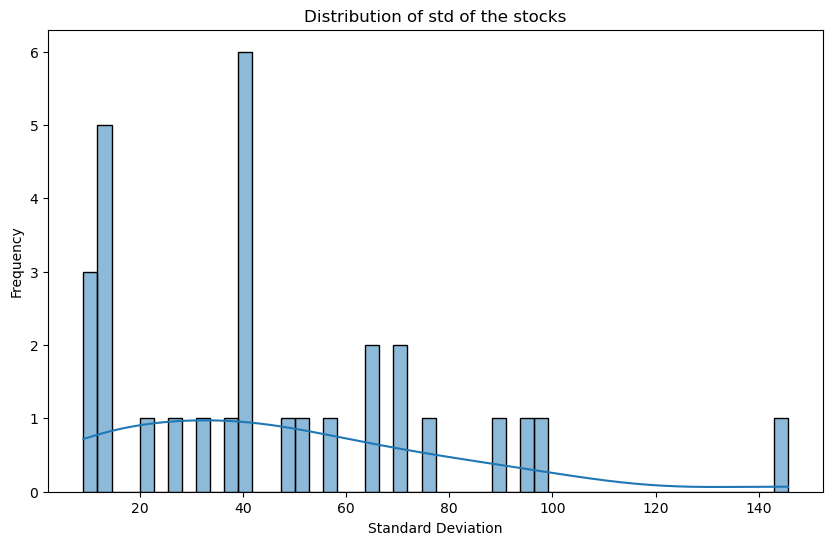

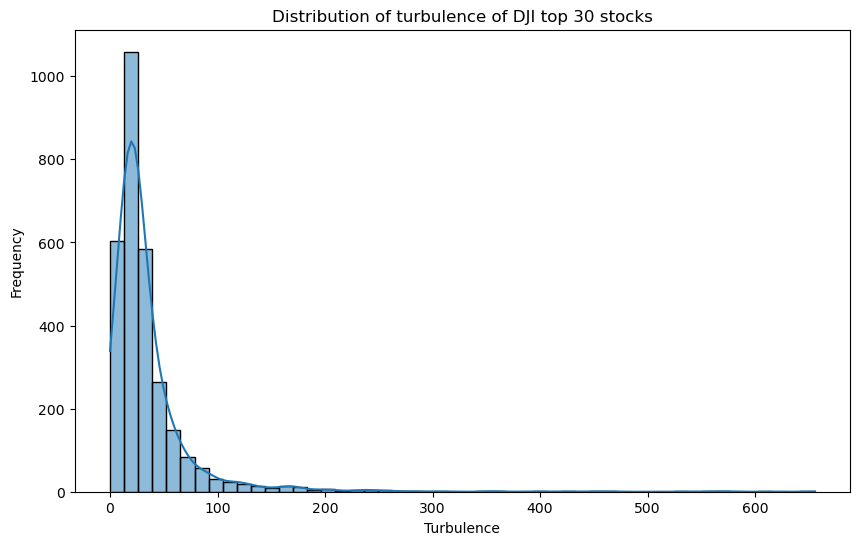

<Figure size 1500x500 with 0 Axes>

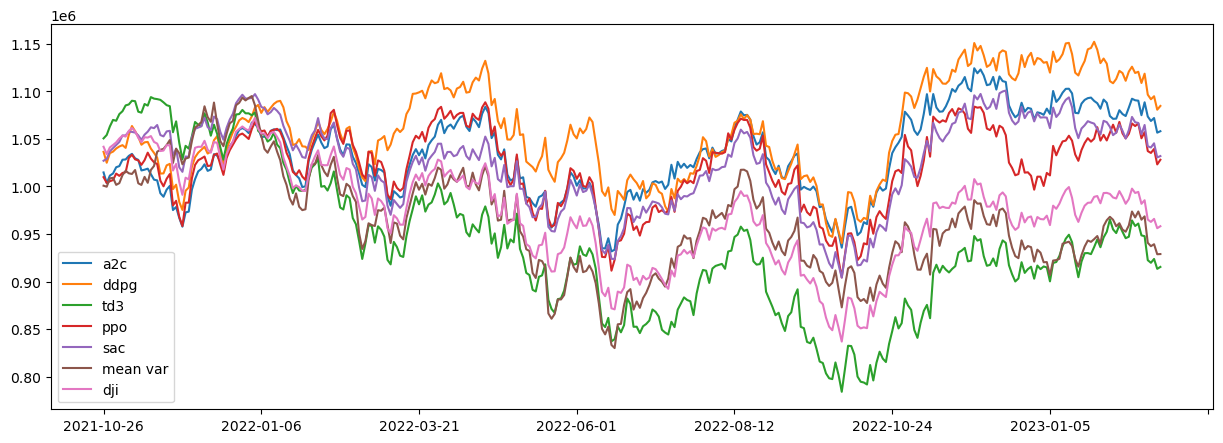

In [61]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();

In [62]:
# make a table of initial and final value, annual return, sharpe ratio, max drawdown
# initial value
initial_value = result.iloc[0]
# final value
final_value = result.iloc[-1]
# annual return
annual_return = (final_value/initial_value)**(1/3) - 1
annual_return = annual_return * 100
# sharpe ratio
sharpe_ratio = annual_return / result.std()
# max drawdown
max_drawdown = (result - result.expanding().max()).min()
# combine all the metrics
metrics = pd.DataFrame([initial_value, final_value, annual_return, sharpe_ratio, max_drawdown], index=['initial_value', 'final_value', 'annual_return', 'sharpe_ratio', 'max_drawdown']).T
metrics.to_csv("metrics_oridji.csv")
print(metrics)

          initial_value   final_value  annual_return  sharpe_ratio  \
a2c        1.014671e+06  1.058016e+06       1.404157      0.000033   
ddpg       1.036320e+06  1.084572e+06       1.528536      0.000031   
td3        1.050455e+06  9.153260e+05      -4.486199     -0.000059   
ppo        1.009710e+06  1.027999e+06       0.600147      0.000015   
sac        1.026972e+06  1.031869e+06       0.158722      0.000003   
mean var   1.000730e+06  9.288668e+05      -2.453395     -0.000045   
dji        1.041671e+06  9.581264e+05      -2.748252     -0.000052   

           max_drawdown  
a2c      -151957.461378  
ddpg     -191816.784805  
td3      -309783.857719  
ppo      -184124.069462  
sac      -192925.196998  
mean var -264967.362362  
dji      -235216.170015  
